In [1]:
import os
import sys

In [2]:
import string
import itertools
import math
import time
import datetime
import json
import pyodbc
import numpy as np
import pandas as pd

from functools import singledispatch
from collections import Counter

# singledispatchmethod in functools from python3.8+
#try:
    #from functools import singledispatchmethod
#except ImportError:
    #from singledispatchmethod import singledispatchmethod

# Gensim
import gensim
import gensim.corpora as corpora

from gensim.utils import simple_preprocess
from gensim.models import LdaModel, CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

import nltk
nltk.download('stopwords') #only on first install

from nltk.corpus import stopwords


import nltk
nltk.download('punkt')

import nltk
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to C:\Users\aih-
[nltk_data]     admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\aih-
[nltk_data]     admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\aih-
[nltk_data]     admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
#Extend stop words
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use','please','au', 'hi','hello','help',
                  'find','cant','one','still','ask','st','yes','im','dont','none','cannot',
                  'want','know','see','whats','could','back','would_like','wondering','able',
                  'hey','need','get','take','like','copy','nan','writing','ok','appreciate',
                  'okay','thanks','make','trying','another','havent','would','thank','yet','receive',
                  'looking','someone', 'contact_us', 'popular_questions','already','idont',
                  'ive','wanted','today','first','information','talk','person','long','work',
                  'week','regarding','questions','two','pm','sent','got','says','whether','youll',
                  'said', 'hi', 'dear', 'hello'])
stop_words.extend(['question', 'related', 'detail','found','otherwise','sorry','understand','try','rephrase','try','go','either',
                  'however','includes','wish','also','sure','may','must','including','would'])
stop_words.extend(['regard', 'give', 'let'])

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [4]:
data_whole = pd.read_csv('Archibus WR Data_2021-2022_20221018.csv')
df = data_whole.head(int(len(data_whole)*(90/100)))
df

,WR_ID,PROB_TYPE,REQUESTOR,STATUS,DATE_REQUESTED,DESCRIPTION,SITE_ID,BL_ID,FL_ID,RM_ID
0,6219244,ELECTRICAL SERVICES,TAWANDA LAWYER CHITSIKE,Clo,4/8/2021 0:00,"Dear COS, the lights in the male toilet on lev...",1.0,F03,03,T302
1,6219892,PLUMBING SERVICES,SALLY CHIK,Rej,4/13/2021 0:00,The zip tap in the library staff room is not w...,2.0,G02,01,116
2,6219909,LIGHTING,ANDREW LONG BAO HUA DUONG,Clo,4/13/2021 0:00,"Lights are currently out, previously occurred ...",2.0,H04,01,124
3,6219912,BLDG ACCESSCARDS,PAUL CHRISTOPHER BROOKS,Com,4/13/2021 0:00,Can i please get access for Celine\tBoehm\t116...,1.0,A28,NaN,NaN
4,6219913,FIRE SERVICES,JOSH MCALPINE,Clo,4/13/2021 0:00,NON CRITICAL DEFECT\nThe syphonics pipe collar...,1.0,B23,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
106424,6744430,ELECTRONIC SECURITY,ZISHI LI,Clo,8/25/2022 0:00,SECURITAS PARTS REQUEST FOR WR 6695571 and C55...,13.0,C55C,01,118
106425,6744438,PLUMBING SERVICES,MARIE KANAAN,Com,8/25/2022 0:00,the women's toilet furthest from the entry is ...,1.0,K25,06,NaN
106426,6744443,ELECTRONIC AUTO DOORS,CHAU CHAK WING MUSEUM,Clo,8/25/2022 0:00,Linked work request (x2) - Approved quote to p...,1.0,F21,B2,CB200
106427,6744450,ELECTRONIC SECURITY,ORLA MCGOVERN,Com,8/25/2022 0:00,"Hello, \n\nWe use A22: 329 329A 330 330A for s...",1.0,A22,03,NaN


In [5]:
#Only pick up useful columns
col = ['PROB_TYPE', 'DESCRIPTION']
df = df[col]
df = df[pd.notnull(df['DESCRIPTION'])]
df.columns = ['PROB_TYPE', 'DESCRIPTION']
df['category_id'] = df['PROB_TYPE'].factorize()[0]
df.head()

,PROB_TYPE,DESCRIPTION,category_id
0,ELECTRICAL SERVICES,"Dear COS, the lights in the male toilet on lev...",0
1,PLUMBING SERVICES,The zip tap in the library staff room is not w...,1
2,LIGHTING,"Lights are currently out, previously occurred ...",2
3,BLDG ACCESSCARDS,Can i please get access for Celine\tBoehm\t116...,3
4,FIRE SERVICES,NON CRITICAL DEFECT\nThe syphonics pipe collar...,4


In [6]:
category_id_df = df[['PROB_TYPE', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)

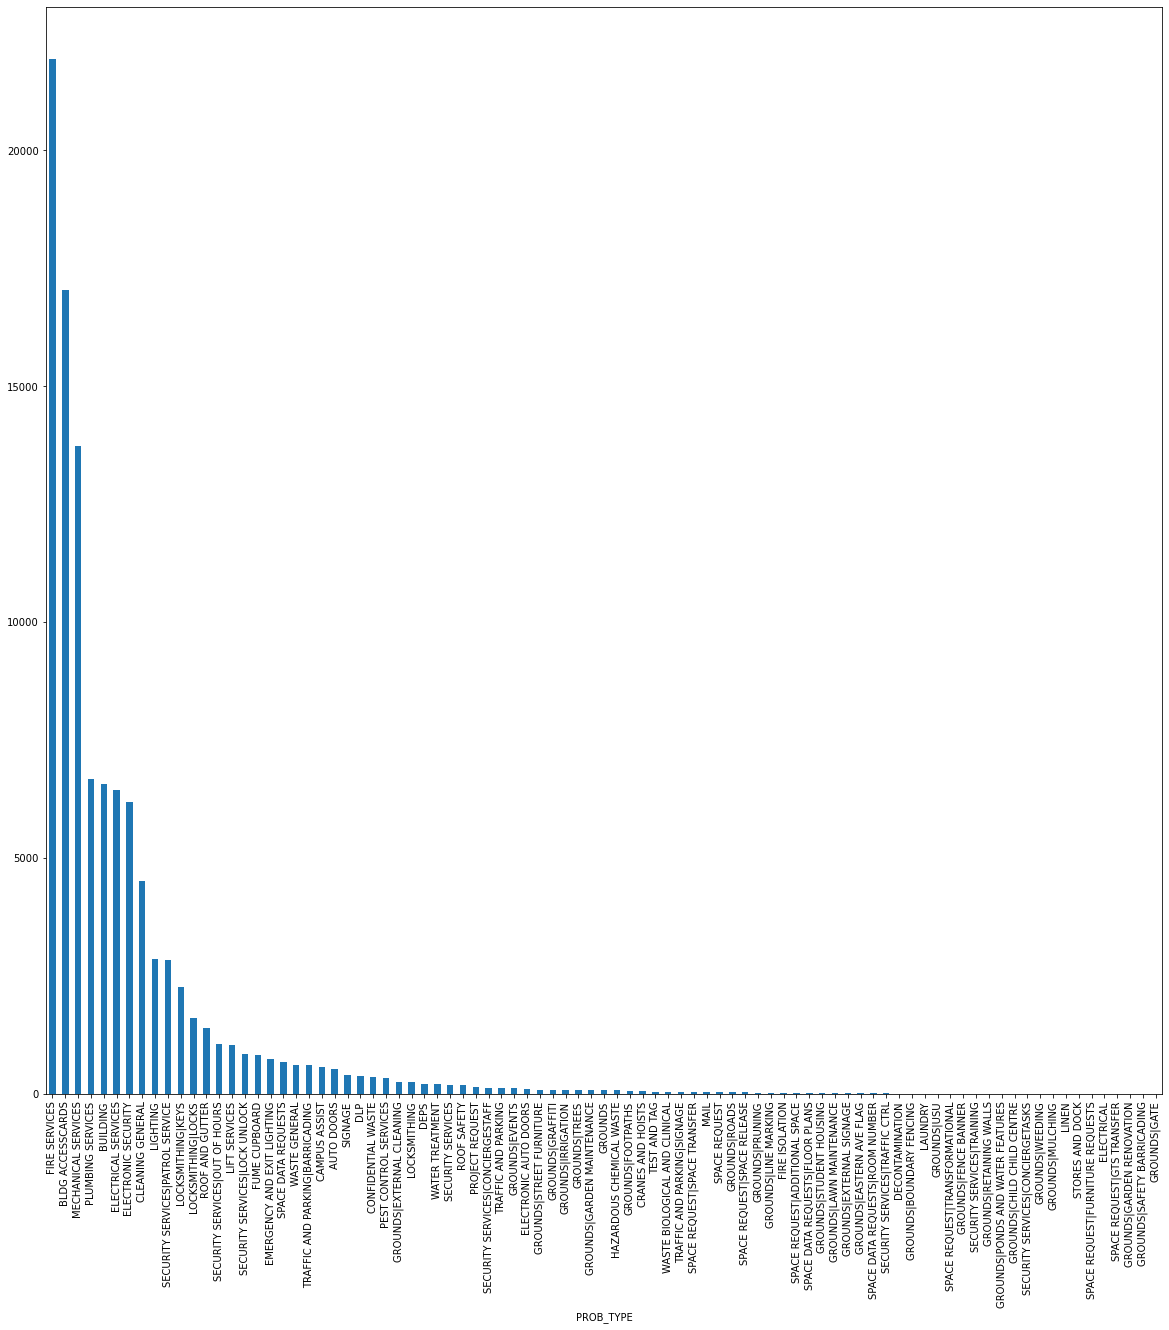

In [7]:
#Visualize how many tickets per category
fig = plt.figure(figsize=(20,20))
df.groupby('PROB_TYPE').DESCRIPTION.count().sort_values(ascending = False).plot.bar(ylim=0)
plt.show()

In [8]:
#Data cleaning
class Preprocessor:
    
    def __init__(self):
        self.punct = list(string.punctuation.replace("'", '’'))
        self.token_list = [
          '|', '------','____','If you have received this email in error ','Any use, distribution, disclosure, or copying of this email','cheers', 'regards', 'best regards', 'kind regards',
          'sent from:', 'from:', 'sent:', 'to:', 'cc:', 'subject:', 'Sender:','date: ',' outlook for', '<https://protect','This short survey will take','how satisfied or dissatisfied are you with our',
          'CISCO', '[image]', '.pdf', '[cid:', 'Giving today. Changing tomorrow.','If you have a different query, you will need to submit a new enquiry', 
          'See the impact<', 'This email plus any attachments to it are confidential. Any unauthori','Read through your handbook<http','find out what you will need to enrol in your new course<https',
          'We acknowledge and respect the', 'Please think of our environment','If you are not satisfied with this response, you can re-open the enquiry',
          'This e-mail may contain information which is confidential', 'Before commencing your research you will need to enrol, to review the details of your approved',
          'This email (including any attachments) may contain confidential','We acknowledge the traditional custodians of the land','This communication may contain information that is proprietary',
          'Views expressed in this email are those of the individual sender, and are not necessarily the views of', 'You can find out how to suspend your studies<https',
          'This email plus any attachments to it are confidential','for any other general enquiries you are welcome to contact the Student Centre',
          '=========', 'Please quote your full name and student number in all correspondence with the University.','Your student card is valid for the duration of your enrolment',
          'Please use your student email account if you are a current student for all communication with the University.','Thinking about taking a break from your studies',
          'The majority of correspondence issued by the University of Sydney is sent via email. In order to ensure','You can find more information about enrolment<',
          'To update this case please click on the link in the email below, or alternatively reply above this lin','After you have successfully enrolled, we will send a confirmation summary to your University student',
          'If you receive this email in error', 'It is strictly forbidden to share any part of this message','If you have any questions, call us on 1800 SYD UNI'
        ]
        self.token_list = [t.lower() for t in self.token_list]
    
    def __call__(self, *args, **kwargs):
        if isinstance(args[0], list):
            [self(arg) for arg in args[0]]
        elif isinstance(args[0], pd.DataFrame):
            self.replace_DESCRIPTION(args[0])
            self.remove_blacklisted_sentences(args[0])
        else:
            raise ValueError
            
    def remove_punctuations(self, text):
        for punctuation in self.punct:
            text = text.replace(punctuation, ' ')
        return text

    def str_blacklist(self, string):
        str_list = string.split('\n')
        return '\n'.join([s for s in str_list if not any(t in s.lower() for t in self.token_list) and len(s) != 0])
      
    def remove_blacklisted_sentences(self, df):
        df['DESCRIPTION'] = df['DESCRIPTION'].apply(self.str_blacklist)

    def replace_DESCRIPTION(self, df):

        df['DESCRIPTION'] = df['DESCRIPTION'].astype(str)
        
        df['DESCRIPTION'] = df['DESCRIPTION'].apply(lambda x: x.lower())
        df['DESCRIPTION'] = df['DESCRIPTION'].apply(lambda x: x.replace('\n', ' '))
        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace('http\S+|www.\S+', '', regex=True)
        df['DESCRIPTION'] = df['DESCRIPTION'].apply(lambda x: x.replace('&gt;', ''))
        df['DESCRIPTION'] = df['DESCRIPTION'].apply(self.remove_punctuations)
        df['DESCRIPTION'] = df['DESCRIPTION'].apply(lambda x: str(x).replace(" s ", " "))

        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace("\r", " ", case=False)

        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace(' university of sydney',' usyd ', case=False)
        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace(' university ', ' usyd ', case=False)
        #df['DESCRIPTION'] = df['DESCRIPTION'].str.replace(' uni ',' usyd ',case=False)  #do not use this line it will mess up unit as usydt
        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace("sydney student","sydney_student",case=False)
        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace("contact us", "contact_us", case=False)
        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace("popular questions","popular_questions", case=False)
        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace(' center ',' centre ',case=False)
        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace("student centre", "student_centre", case=False)
        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace("unit of study","unit_of_study", case=False)

        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace(" units of study "," unit_of_study ",case=False)

        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace(" masters "," master ", case=False)

        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace("online enquiry", "online_enquiry", case=False)
        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace("online inquiry", "online_inquiry", case=False)

        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace(" re enrol "," re_enrol ", case=False)
        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace(" enroll ", " enrol ", case=False)
        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace(" enrolment "," enrol ",case=False)
        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace(" enroling "," enrol ",case=False)
        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace(" enroled "," enrol ",case=False)
        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace(" enrolled "," enrol ", case=False)

        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace(" re enrollment ", " re_enrol ", case=False)
        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace(" student id " , " student_id ", case=False)
        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace(" log into "," login ",case=False)
        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace(" log in "," login ",case=False)

        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace("error message ", " error_message ", case=False)

        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace(" international students ", " international_students ", case=False)
        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace(" international student ", " international_students ", case=False)
        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace(" first year ", " first_year ", case=False)
        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace(" final year ", " final_year ", case=False)

        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace(" census date ", " census_date ", case=False)
        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace(" none of the above ", " none_of_the_above ", case=False)
        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace(' units ',' unit ', case=False)

        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace(" SID ", " student_id ", case=False)

        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace(" summer school "," summer_school ",case=False)

        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace(" collecting "," collection ",case=False)
        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace(" collect "," collection ",case=False)

        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace(" studies "," study ",case=False)
        #new
        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace(" students ", " student ", case=False)
        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace(" covid", " coronavirus ", case=False)
        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace(" corona virus ", " coronavirus ", case=False)
        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace(" suspension ", " suspend ", case=False)
        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace(" universitys ", " usyd ", case=False)
        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace(" begin ", " start ", case=False)
        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace(" face to face ", " face_to_face", case=False)
        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace(" reenrol", " re_enrol", case=False)
        df['DESCRIPTION'] = df['DESCRIPTION'].str.replace(" australian ", " australia ", case=False)
        #Remove any str with numbers
        df['DESCRIPTION'] = df.DESCRIPTION.str.replace(r'\w*\d\w*','')

In [9]:
preprocessor = Preprocessor()
preprocessor(df)

In [33]:
from nltk.tokenize import word_tokenize
# check for NaN values and remove them (optional)
df['DESCRIPTION'].dropna(inplace=True)

# convert the column to string
df['DESCRIPTION'] = df['DESCRIPTION'].astype(str)

# apply the `word_tokenize()` function
token_words = df['DESCRIPTION'].apply(word_tokenize)

from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()

text = token_words.apply(lambda x: ' '.join([lemmatizer.lemmatize(w) for w in x]))
text

0         dear co the light in the male toilet on level ...
1         the zip tap in the library staff room is not w...
2         light are currently out previously occurred in...
3         can i please get access for celine boehm to op...
4         non critical defect the syphonics pipe collar ...
                                ...                        
106424    securitas part request for wr and lock lock fa...
106425    the woman 's toilet furthest from the entry is...
106426    linked work request approved quote to proceed ...
106427    hello we use for staff meeting workshop and se...
106428    the light cover ha fallen off the light and sm...
Name: DESCRIPTION, Length: 106427, dtype: object

In [34]:
#Pick up keywords
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words=stop_words, ngram_range=(1,2), norm = 'l2', min_df = 18) 
features = tfidf.fit_transform(text).toarray()

labels = df.category_id
features.shape

(106427, 16935)

In [35]:
from sklearn.feature_selection import chi2

In [36]:
# Finding the 15 most correlated terms with each of the PROB_TYPE
N = 15
a, b, c= [], [], []
for PROB_TYPE, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    a.append(PROB_TYPE), 
    b.append("%s" %(', '.join(unigrams[-N:])))
    c.append("%s" %(', '.join(bigrams[-N:])))

In [37]:
rows = [a,b,c]

In [38]:
col = ['PROB_TYPE', 'Unigram Keywords', 'Bigram Keywords']

In [39]:
#Export as csv file
import csv
with open ('Output.csv', 'w') as f:
    write = csv.writer(f)
    write.writerow(col)
    write.writerows(zip(*rows))